In [47]:
import time

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19

In [48]:
def load_image_as_batch_with_optional_resize(path, newH=None, newW=None):
    img = skimage.io.imread(path)
    img = img / 255.0
    
    oldH, oldW = img.shape[0], img.shape[1] # assume h,w is shape[0] and [1] respectively
    if newH != None or newW != None:
        if newW is None:
            newW = int(oldW * float(newH) / oldH)
        elif newH is None:
            newH = int(oldH * float(newW) / oldW)
        img = skimage.transform.resize(img, (newH, newW))
    
    # delete the Alpha channel if the image is RGBA to make sure # channel is correct
    if img.shape[2]==4:
        img = img[:,:,0:3]
        
    # add another dimension to make it a batch , bacause our vgg19 def takes a batch
    img = img.reshape((1,)+img.shape)
    return img

(1, 256, 341, 3)
(1, 600, 1800, 3)


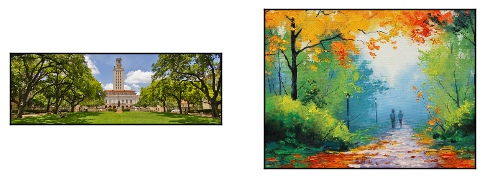

In [49]:
CONTENT_LAYER = 'conv3_2'
STYLE_LAYERS = ('conv1_2', 'conv2_2', 'conv3_2', 'conv4_2')

class ARG:pass
arg = ARG()
arg.gen_img_height=500

styleimg = load_image_as_batch_with_optional_resize('./styles/nice_style2.jpg', newH=256)
print(styleimg.shape)
# contentimg = load_image_as_batch_with_optional_resize('./brad_pitt.jpg', newH=arg.gen_img_height)
contentimg = load_image_as_batch_with_optional_resize('ut_trees.png',newH=600)
print(contentimg.shape)

arg.gen_img_width = contentimg.shape[1] # computed from aspect ratio of content_img
# show image
_,axes=plt.subplots(1,2)
axes[0].imshow(contentimg[0]); axes[1].imshow(styleimg[0])
axes[0].xaxis.set_visible(False);axes[1].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False);axes[1].yaxis.set_visible(False)
plt.show()

In [50]:
sess=tf.Session()
img_pl = tf.placeholder(tf.float32)
vgg19factory = custom_vgg19.Vgg19Factory()
vgg19 = vgg19factory.build(img_pl)

print(styleimg.shape)
conv31feat = sess.run(vgg19.conv3_1, feed_dict={img_pl:styleimg})
print(conv31feat.shape)

/work/04006/zhuode93/maverick/dlproj2/trainable-neural-style/tensorflow_vgg/vgg19.npy
npy file loaded
(1, 256, 341, 3)
(1, 64, 86, 256)


In [51]:
def gram_matrix(feat_map):
    assert isinstance(feat_map, tf.Tensor)
    shape = tf.cast(tf.shape(feat_map), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    F = tf.reshape(feat_map, [-1, tf.cast(ch,tf.int32)])
    
    # TODO: if m<n, compute feat_map*feat_map, else compute feat_map'*feat_map 
    gram = tf.matmul(F, F, transpose_a=True) / h / w / ch # not sure why  we have"/ ch". if not, the style_loss is too big
    return gram

def compute_style_loss(gram_of_feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map2), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    G1, G2 = gram_of_feat_map1, gram_matrix(feat_map2)
    style_loss = tf.nn.l2_loss((G1-G2))/ (ch**2) # ch^2 is #element in G1, G2
    return style_loss

def compute_content_loss(feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map1), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    content_loss = tf.nn.l2_loss(feat_map1-feat_map2)/h/w/ch
    return content_loss

In [52]:
batch_shape = contentimg.shape
img_gen = tf.Variable(tf.truncated_normal(contentimg.shape,  mean=0.5, stddev=0.1))
vgg19_pred= vgg19factory.build(img_gen)

In [53]:

# precompute content/style image's stuffs
style_layers_target = [getattr(vgg19, l) for l in STYLE_LAYERS]
content_layer_target = getattr(vgg19, CONTENT_LAYER)
styleimg_grams_np = [sess.run(gram_matrix(l), feed_dict={img_pl:styleimg}) for l in style_layers_target]
contentimg_feat_map_np = sess.run(content_layer_target, feed_dict={img_pl:contentimg})
styleimg_grams = [tf.constant(g, dtype=tf.float32) for g in styleimg_grams_np]
contentimg_feat_map = tf.constant(contentimg_feat_map_np, dtype=tf.float32)

style_layers_pred = [getattr(vgg19_pred, name) for name in STYLE_LAYERS]
content_layer_pred = getattr(vgg19_pred, CONTENT_LAYER)

In [54]:
sess.run(img_gen.initializer)

style_losses = [compute_style_loss(src, dst) for (src,dst) in zip(styleimg_grams,style_layers_pred)]
style_loss_np = sess.run(style_losses)
print 'initial style loss: ' + str(style_loss_np)

content_loss = compute_content_loss(contentimg_feat_map, content_layer_pred)
[content_loss_np] =sess.run([content_loss])
print('initial content loss = %f' % content_loss_np)

# total variation denoising
bsize, h , w, ch = batch_shape
y_tv = tf.nn.l2_loss(img_gen[:,1:,:,:] - img_gen[:,:h-1,:,:])
x_tv = tf.nn.l2_loss(img_gen[:,:,1:,:] - img_gen[:,:,:w-1,:])
tv_loss = (x_tv + y_tv)/(bsize*h*w*ch)
[tv_loss_np] =sess.run([tv_loss])
print('initial TV loss = %f' % tv_loss_np)

total_loss =  20 * reduce(tf.add, style_losses) + 5 * content_loss + 100000 * tv_loss
[total_loss_np] = sess.run([total_loss])
print('initial total loss = %f' % total_loss_np)

initial style loss: [93937.641, 13024.594, 1642.2518, 5104.5215]
initial content loss = 10876.344727
initial TV loss = 0.015448
initial total loss = 2330106.750000


In [55]:
temp = set(tf.all_variables())
train_op = tf.train.AdamOptimizer(0.02).minimize(total_loss)
#I honestly don't know how else to initialize ADAM in TensorFlow.
sess.run(tf.initialize_variables(set(tf.all_variables()) - temp))

In [64]:
# start optimization
iter = 0
MAX_ITER = 200

while iter < MAX_ITER:
    sess.run(train_op)
    iter += 1
    if iter % 10 == 0:
        print(sess.run([total_loss]+style_losses+ [content_loss, tv_loss]))

[29052.719, 13.91868, 65.185707, 65.291061, 87.918465, 4706.7715, 0.0087258201]
[28930.621, 13.662205, 64.963272, 65.346489, 87.865662, 4685.458, 0.0086658048]
[28812.975, 13.423632, 64.761337, 65.413399, 87.835114, 4664.686, 0.0086087482]
[28699.543, 13.200867, 64.57502, 65.477791, 87.82148, 4644.5195, 0.0085544176]
[28590.377, 12.988906, 64.383629, 65.533394, 87.789818, 4625.2393, 0.0085026743]
[28484.904, 12.790707, 64.213943, 65.605164, 87.781105, 4606.3491, 0.0084533906]
[28383.357, 12.603347, 64.071594, 65.685036, 87.786026, 4587.9585, 0.00840645]
[28286.135, 12.428772, 63.929672, 65.776901, 87.80307, 4570.2354, 0.0083619012]
[28192.967, 12.262817, 63.787998, 65.863564, 87.817215, 4553.2769, 0.0083195111]
[28103.189, 12.109863, 63.649506, 65.924698, 87.807884, 4537.0918, 0.0082789352]
[28016.785, 11.966017, 63.536579, 65.999672, 87.808258, 4521.3115, 0.0082401615]
[27933.51, 11.828027, 63.428631, 66.078323, 87.821785, 4506.0078, 0.008203364]
[27853.086, 11.692657, 63.308418, 66.1

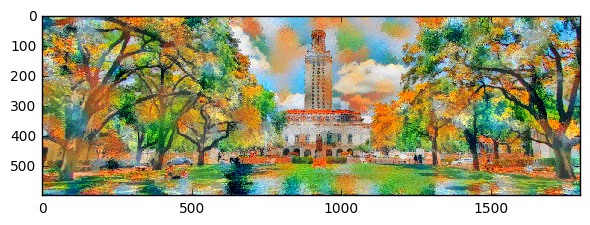

In [62]:

img_gen_clipped = tf.clip_by_value(img_gen, 0,1) #  the range of values in generated image will fall out of [0,1].
            # If you scale it to [0,1] instead of clipping it to [0,1], the image will look "grey"
img_gen_np = np.squeeze(sess.run(img_gen_clipped), 0)
skimage.io.imshow(img_gen_np)
plt.show()

In [65]:
plt.imsave('ut_trees_nicestyle2.jpg',img_gen_np)